In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lectura de datos

In [2]:
df_base = pd.read_csv(r'..\data\raw\base_train.csv',sep='|', encoding='utf-8')
df_base.head()

,num_doc,f_analisis,default,tipo_cliente,trx39,trx102,trx106,trx143,trx158,disp309,...,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
0,7.283207e+08,201810,0,adicion,1.213352,0.000000,0.000000,0.000000,0.242403,8.0,...,28.24,3.20,28.57,33.33,10.0,2.0,0.99,1.0,100.0,-3.00000
1,1.242291e+10,201801,1,adicion,0.000000,0.000000,0.000001,0.000000,0.000000,8.0,...,-1.00,-1.00,60.00,-1.00,4.0,3.0,-1.00,-1.0,0.0,-1.00000
2,3.419426e+10,201803,0,adicion,0.953794,0.000000,0.000000,0.404773,0.203330,11.0,...,14.56,20.48,75.00,90.91,15.0,3.0,1.50,0.0,100.0,100.00000
3,3.601473e+10,201807,0,adicion,2.236068,0.000010,0.000003,0.424556,1.227298,8.0,...,-3.00,0.38,28.57,0.00,8.0,2.0,-4.00,-2.0,-3.0,-2.00000
4,5.051837e+10,201811,0,adicion,2.361438,0.000001,0.000023,0.000000,0.392063,0.0,...,74.66,32.00,33.33,81.82,16.0,2.0,0.00,3.0,100.0,89.22658


In [3]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28276 entries, 0 to 28275
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_doc       28276 non-null  float64
 1   f_analisis    28276 non-null  int64  
 2   default       28276 non-null  int64  
 3   tipo_cliente  28276 non-null  object 
 4   trx39         28276 non-null  float64
 5   trx102        28276 non-null  float64
 6   trx106        28276 non-null  float64
 7   trx143        28276 non-null  float64
 8   trx158        28276 non-null  float64
 9   disp309       28276 non-null  float64
 10  CO01END010RO  28276 non-null  float64
 11  CO01ACP017CC  28276 non-null  float64
 12  CO02EXP011TO  28276 non-null  float64
 13  CO02EXP004TO  28276 non-null  float64
 14  CO01EXP001CC  28276 non-null  float64
 15  CO01EXP003RO  28276 non-null  float64
 16  CO02END015CC  28276 non-null  float64
 17  CO01END002RO  28276 non-null  float64
 18  CO01END086RO  28276 non-nu

# creacion variables utilidad

In [4]:
import pandas as pd
import numpy as np

def generar_variables_derivadas(df):
    # Asegurar que f_analisis sea string
    df["f_analisis"] = df["f_analisis"].astype(str)
    
    # Extraer año y mes
    df["anio"] = df["f_analisis"].str[:4].astype(int)
    df["mes"] = df["f_analisis"].str[4:].astype(int)

    # Diferencias de antigüedad entre productos
    df["antiguedad_dif_telcos"] = df["CO01EXP001CC"] - df["CO02EXP004TO"]
    df["antiguedad_dif_ahorro_rot"] = df["CO01EXP003RO"] - df["CO01EXP002AH"]

    # Utilización financiera transformada
    df["utilizacion_actual"] = 1 - df["CO01END010RO"] / (df["CO01END094RO"] + 1e-6)
    df["variacion_saldo_9m"] = df["CO01END002RO"] - df["CO01END051RO"]
    df["relacion_saldo_cupo"] = df["CO01END002RO"] / (df["CO01END094RO"] + 1e-6)

    # Comportamiento transaccional
    df["delta_trx_mes"] = df["trx102"] - df["trx106"]

    # Binning categorizado
    df["util_cat"] = pd.cut(df["utilizacion_actual"], bins=[-np.inf, 0.3, 0.7, np.inf], labels=["baja", "media", "alta"])
    df["mora_rot_cat"] = pd.cut(df["CO01MOR098RO"], bins=[-np.inf, 0.7, 0.9, 1.0], labels=["mala", "media", "buena"])
    df["mora_total_cat"] = pd.cut(df["CO02MOR092TO"], bins=[-np.inf, 0.7, 0.9, 1.0], labels=["mala", "media", "buena"])
    df["var_saldo_cat"] = pd.cut(df["variacion_saldo_9m"], bins=[-np.inf, 0, np.inf], labels=["deterioro", "mejora"])

    # Flags de riesgo y oportunidad
    df["bandera_riesgo_1"] = ((df["variacion_saldo_9m"] < 0) & (df["utilizacion_actual"] > 0.7)).astype(int)
    df["bandera_oportunidad_telcos"] = ((df["CO01EXP001CC"] < 12) & (df["CO02MOR092TO"] > 0.9)).astype(int)

    return df

df_base = generar_variables_derivadas(df_base)

# Limpieza de la informacion

## Tipologia de las variables

Se encontro que la tipologia de las variables va muy acorde a lo que se entrega en el archivo de diccionario, por lo tanto se deja tal cual esta

## Limpieza profunda de las variables

In [5]:
df = df_base.copy()
df.drop(columns=['num_doc','f_analisis'], inplace=True)

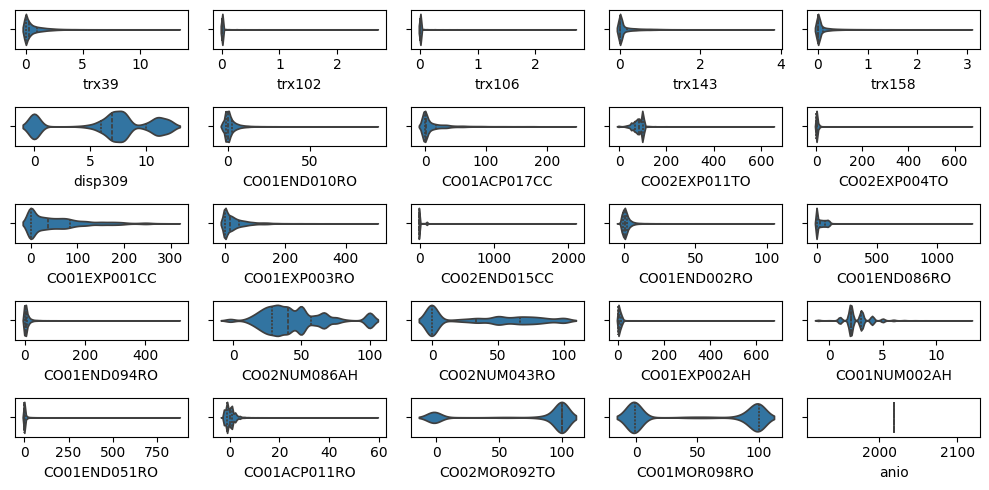

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtramos solo columnas numéricas (excluye f_analisis si lo parseaste a datetime)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['default']).columns

# Boxplots para detectar outliers por variable
plt.figure(figsize=(10,5))
for i, col in enumerate(numeric_cols[:25]):  # puedes ajustar el rango
    plt.subplot(5, 5, i + 1)
    sns.violinplot(x=df[col], inner='quartile')
plt.tight_layout()
plt.show()

# Alternativa: resumen estadístico extendido
# df[numeric_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])


reconversion de variables numericas a categoricas

In [7]:
# 1. CO01MOR098RO – Cumplimiento Rotativo últimos 24 meses
df['CO01MOR098RO'] = pd.cut(df['CO01MOR098RO'], 
                                bins=[-0.01, 25, 75, 100], 
                                labels=['bajo', 'medio', 'alto'])
# Esta variable presenta una distribución polarizada que representa mejor el riesgo cuando se agrupa por niveles de cumplimiento.

# 2. CO02MOR092TO – Cumplimiento Total últimos 18 meses
df['CO02MOR092TO'] = pd.cut(df['CO02MOR092TO'], 
                                bins=[-0.01, 25, 75, 100], 
                                labels=['bajo', 'medio', 'alto'])
# Dado su comportamiento extremo y poco continuo, agrupar este score mejora la estabilidad del modelo y su interpretación.

# 3. disp309 – Versión de SO móvil
df['disp309'] = pd.cut(df['disp309'], 
                           bins=[0, 5, 9, 20], 
                           labels=['bajo', 'medio', 'alto'])
# La versión del sistema operativo refleja un nivel digital y económico que es mejor tratado como variable ordinal categórica.

# 4. CO01NUM002AH – Número de cuentas de ahorro
df['CO01NUM002AH'] = pd.cut(df['CO01NUM002AH'], 
                                bins=[-0.01, 0, 2, 5, 20], 
                                labels=['sin_ahorro', 'bajo', 'medio', 'alto'])
# Agrupar el número de productos de ahorro permite identificar niveles de bancarización con mayor valor explicativo.

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28276 entries, 0 to 28275
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   default                     28276 non-null  int64   
 1   tipo_cliente                28276 non-null  object  
 2   trx39                       28276 non-null  float64 
 3   trx102                      28276 non-null  float64 
 4   trx106                      28276 non-null  float64 
 5   trx143                      28276 non-null  float64 
 6   trx158                      28276 non-null  float64 
 7   disp309                     22274 non-null  category
 8   CO01END010RO                28276 non-null  float64 
 9   CO01ACP017CC                28276 non-null  float64 
 10  CO02EXP011TO                28276 non-null  float64 
 11  CO02EXP004TO                28276 non-null  float64 
 12  CO01EXP001CC                28276 non-null  float64 
 13  CO01EXP003RO    

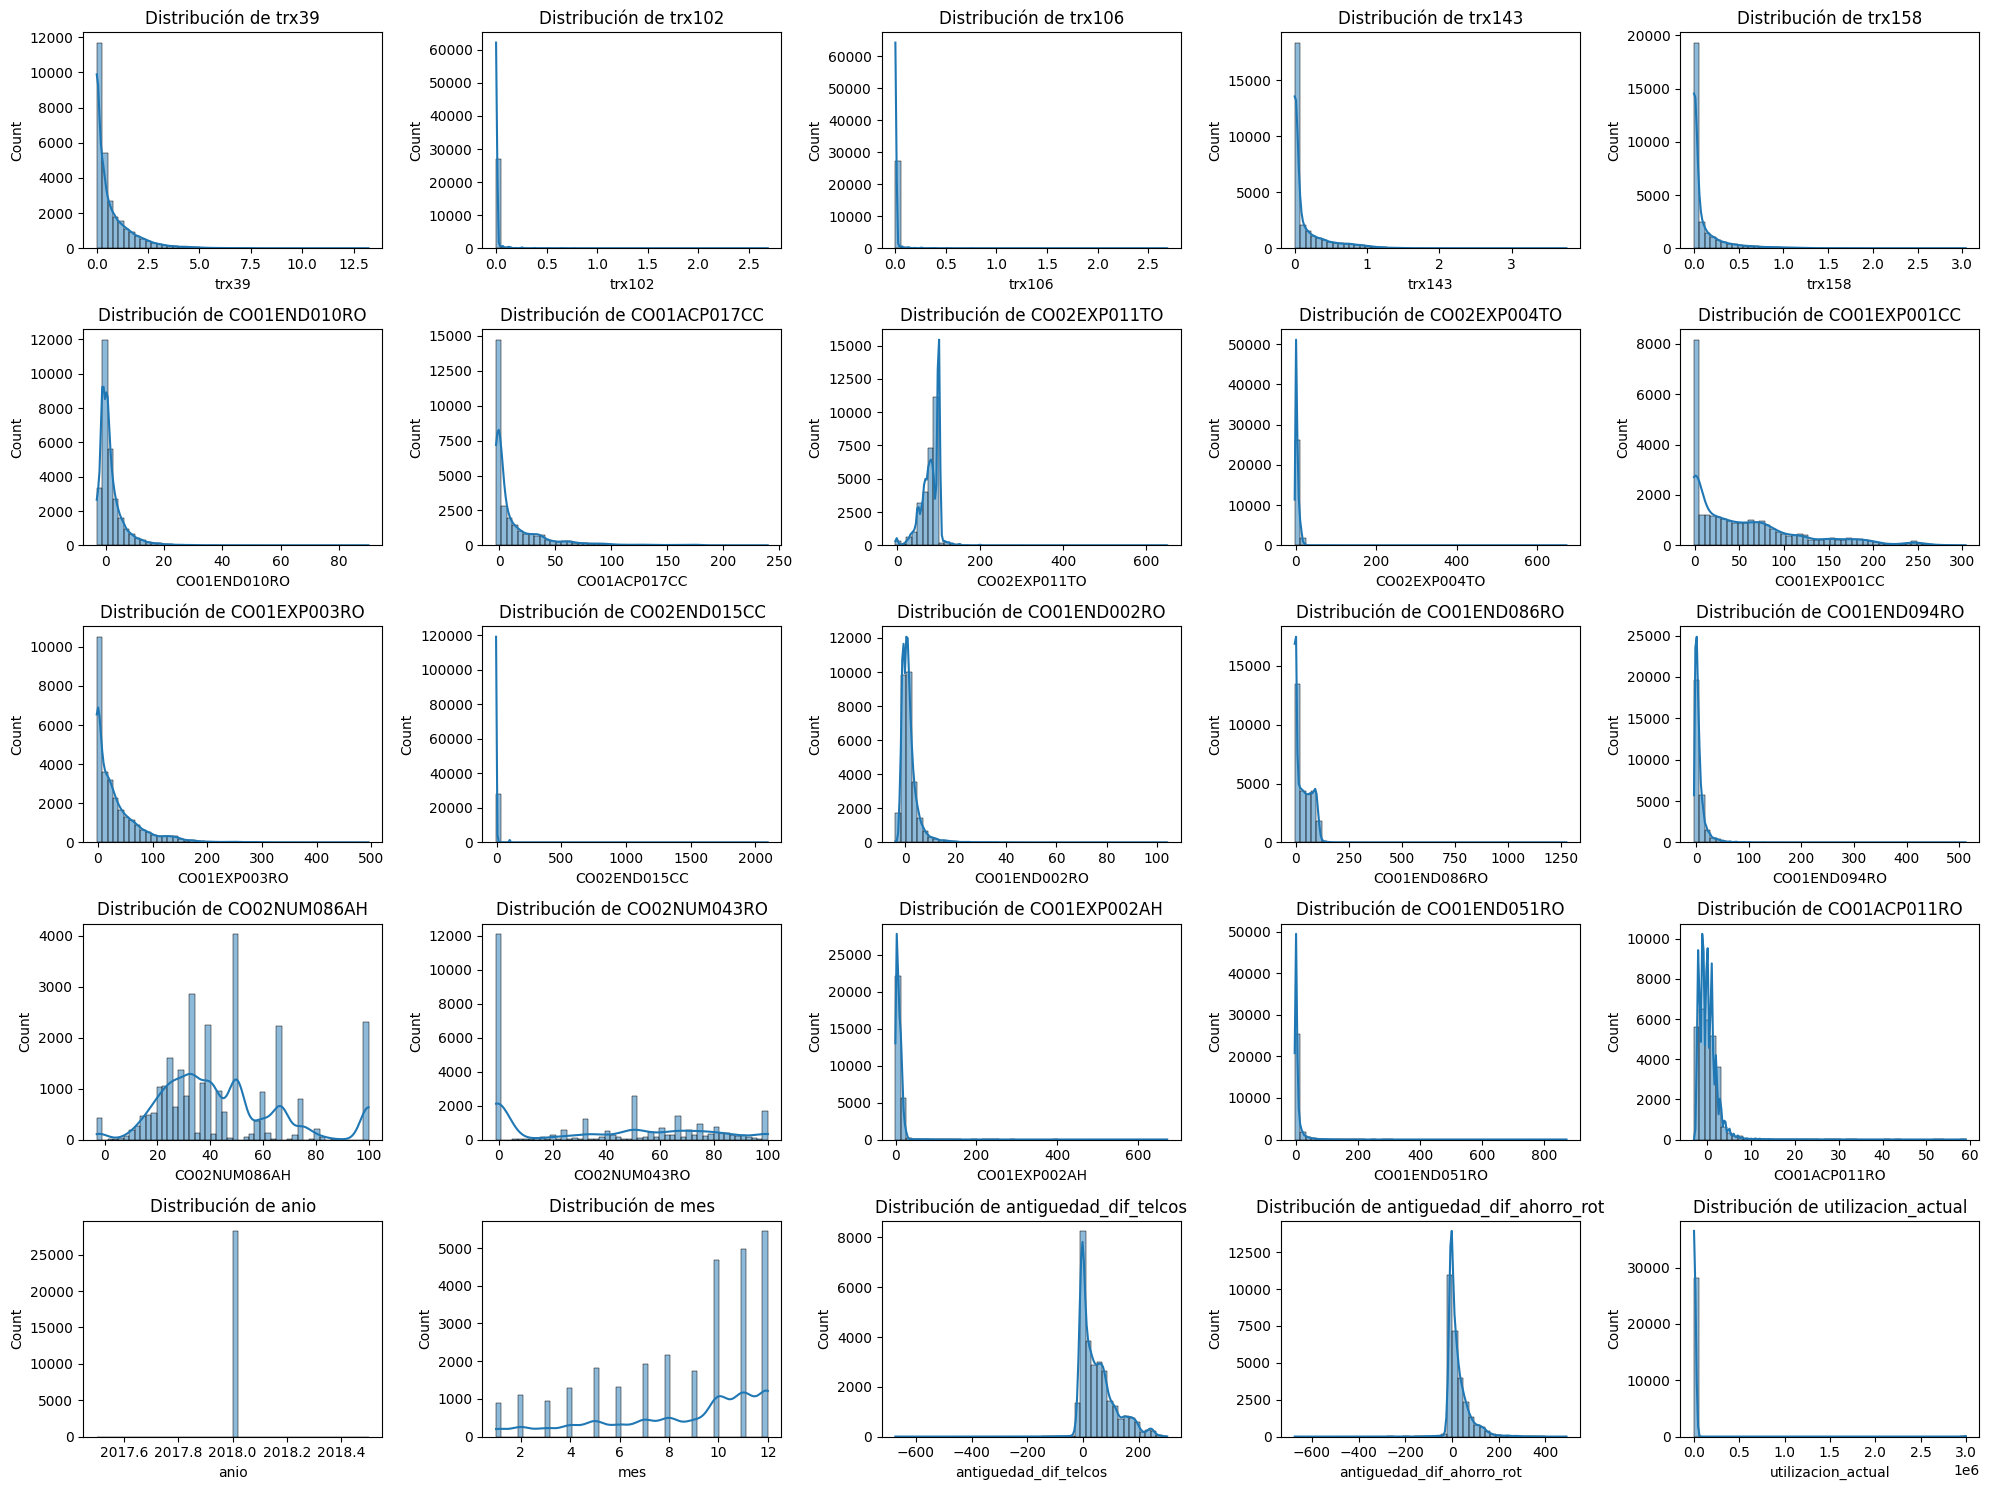

Variables con alta asimetría: ['relacion_saldo_cupo', 'CO02END015CC', 'CO02EXP004TO', 'utilizacion_actual', 'CO01EXP002AH', 'trx102', 'trx106', 'CO01END051RO', 'CO01END094RO', 'CO01END002RO', 'CO01ACP011RO', 'trx158', 'CO01END010RO', 'CO01ACP017CC', 'CO01END086RO', 'trx143', 'trx39', 'CO01EXP003RO', 'bandera_oportunidad_telcos', 'antiguedad_dif_ahorro_rot', 'bandera_riesgo_1', 'CO01EXP001CC']
Cantidad de variables con alta asimetría: 22 de un total de 30


In [8]:
numeric_cols_v2 = df.select_dtypes(include=['float64', 'int64']).drop(columns=['default']).columns


# Asegurarse de que 'df' y 'numeric_cols' ya estén definidos
num_plots = len(numeric_cols_v2[:25])
ncols = 5
nrows = (num_plots + ncols - 1) // ncols  # Cálculo para determinar el número de filas necesarias

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()

# Histograma de distribución (para detectar sesgo positivo)
for ax, col in zip(axes, numeric_cols_v2[:25]):
    sns.histplot(df[col], kde=True, bins=50, ax=ax)
    ax.set_title(f'Distribución de {col}')

# Ocultar ejes extra si es que existen
for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Revisión de skewness (asimetría)
skewness = df[numeric_cols_v2].skew().sort_values(ascending=False)

# Identificar variables candidatas para log1p (log(1+x))
log_candidates = skewness[skewness > 1.0].index.tolist()
print("Variables con alta asimetría:", log_candidates)
print(f'Cantidad de variables con alta asimetría: {len(log_candidates)} de un total de {len(numeric_cols_v2)}')

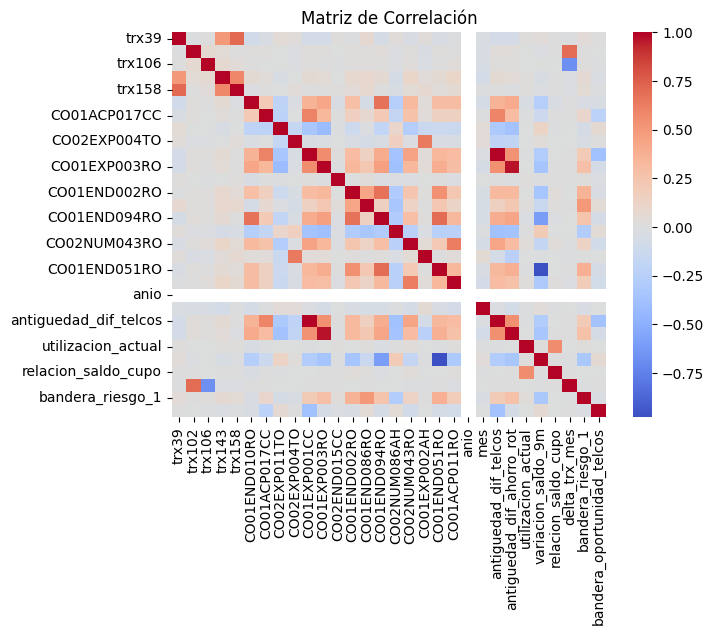

In [9]:
# Matriz de correlación
corr_matrix = df[numeric_cols_v2].corr()

# Visualización con mapa de calor
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, center=0,) # nombre parametro para solo ver los valores de correlación : 
plt.title('Matriz de Correlación')
plt.show()


In [10]:
# Generamos el dataframe de pares: variable 1, variable 2 y la correlación entre ambas
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'correlation'})
)
corr_pairs['abs_correlation'] = corr_pairs['correlation'].abs()

corr_pairs[corr_pairs['abs_correlation'] > 0.5].sort_values(by='abs_correlation', ascending=False).head(10)

,var1,var2,correlation,abs_correlation
227,CO01EXP001CC,antiguedad_dif_telcos,0.985297,0.985297
356,CO01END051RO,variacion_saldo_9m,-0.977411,0.977411
246,CO01EXP003RO,antiguedad_dif_ahorro_rot,0.961686,0.961686
3,trx39,trx158,0.712149,0.712149
52,trx102,delta_trx_mes,0.692809,0.692809
304,CO01END094RO,CO01END051RO,0.691171,0.691171
271,CO01END002RO,CO01END094RO,0.670949,0.670949
138,CO01END010RO,CO01END094RO,0.670909,0.670909
78,trx106,delta_trx_mes,-0.670873,0.670873
204,CO02EXP004TO,CO01EXP002AH,0.640431,0.640431


### Logaritmacion

In [11]:
variables_log = [
    "trx39", "trx102", "trx106", "trx143", "trx158",
    "CO01END010RO", "CO01ACP017CC", "CO02EXP011TO", "CO02EXP004TO",
    "CO01EXP001CC", "CO01EXP003RO", "CO02END015CC", "CO01END002RO",
    "CO01END086RO", "CO01END094RO", "CO02NUM043RO", "CO01EXP002AH",
    "CO01END051RO", "CO01ACP011RO", "CO01MOR098RO", "CO02MOR092TO",
    "relacion_saldo_cupo", "variacion_saldo_9m", "utilizacion_actual",
    "delta_trx_mes"
]
def aplicar_logaritmica(df, variables_log):
    for col in variables_log:
        if col in df.columns:
            try:
                df[f"log_{col}"] = np.log1p(df[col].astype(float))
            except Exception as e:
                print(f"⚠️ No se pudo transformar '{col}': {e}")
    return df

df = aplicar_logaritmica(df, variables_log)


⚠️ No se pudo transformar 'CO01MOR098RO': Cannot cast object dtype to float64
⚠️ No se pudo transformar 'CO02MOR092TO': Cannot cast object dtype to float64


c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **

### Limpieza outliers

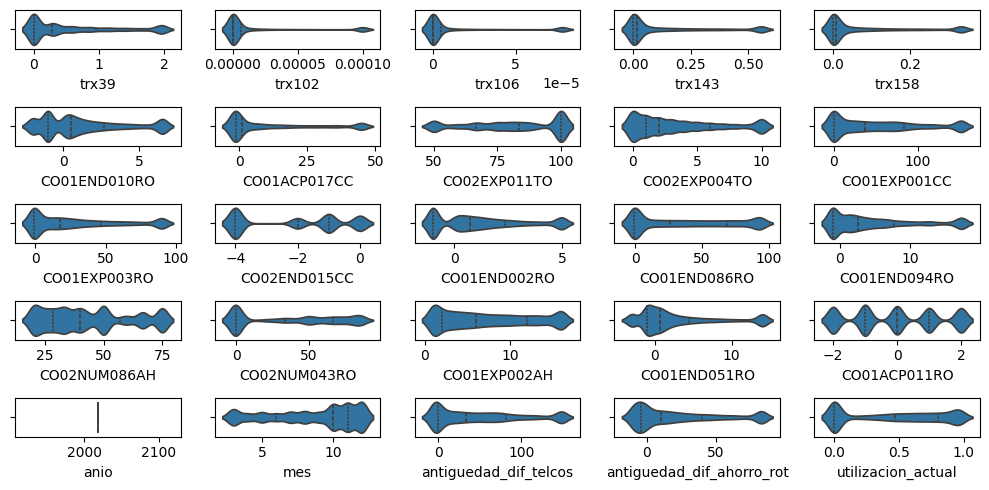

In [12]:
def winsorize_series(s, lower=0.1, upper=0.9):
    lower_val = s.quantile(lower)
    upper_val = s.quantile(upper)
    return s.clip(lower=lower_val, upper=upper_val)

# Aplicar en variables identificadas
for col in numeric_cols_v2:
    df[col] = winsorize_series(df[col])

# graficar nuevamente para ver el efecto de winsorización
plt.figure(figsize=(10,5))
for i, col in enumerate(numeric_cols_v2[:25]):  # puedes ajustar el rango
    plt.subplot(5, 5, i + 1)
    sns.violinplot(x=df[col], inner='quartile')
plt.tight_layout()
plt.show()

## Analisis de valores nulos y duplicados

In [13]:
df_limpio = df.copy()

print(f'Cantidad de valores duplicados: {df_limpio.duplicated().sum()}')
# Eliminar duplicados
df_limpio.drop_duplicates(inplace=True)
print(f'Cantidad de valores duplicados luego de eliminar: {df_limpio.duplicated().sum()}')

Cantidad de valores duplicados: 119
Cantidad de valores duplicados luego de eliminar: 0


In [14]:
df_limpio.isna().sum()

default                       0
tipo_cliente                  0
trx39                         0
trx102                        0
trx106                        0
                           ... 
log_CO01ACP011RO           5596
log_relacion_saldo_cupo      25
log_variacion_saldo_9m     9348
log_utilizacion_actual        0
log_delta_trx_mes            20
Length: 63, dtype: int64

In [15]:
import plotly.express as px

# Calcular porcentaje de valores nulos por columna
porcentaje_nulos = round(df_limpio.isnull().mean(),4) * 100
porcentaje_nulos = porcentaje_nulos.reset_index()
porcentaje_nulos.columns = ['Columna', 'Porcentaje de Nulos']

# Crear gráfico interactivo
fig = px.bar(porcentaje_nulos,
             x='Columna',
             y='Porcentaje de Nulos',
             title='Porcentaje de valores nulos por columna')

fig.update_layout(xaxis_tickangle=-90)

fig.show()


In [16]:
import numpy as np

# 1. Imputar variables categóricas con 'desconocido'
categorical_with_nans = ['disp309', 'CO02MOR092TO', 'CO01MOR098RO']
for col in categorical_with_nans:
    if 'desconocido' not in df_limpio[col].cat.categories:
        df_limpio[col] = df_limpio[col].cat.add_categories('desconocido')
    df_limpio[col] = df_limpio[col].fillna('desconocido')

# 2. Imputar variable discreta con moda
df_limpio['CO01NUM002AH'] = df_limpio['CO01NUM002AH'].fillna(df_limpio['CO01NUM002AH'].mode()[0])

# 3. Imputar variables categorizadas tipo binning
for col in ['mora_rot_cat', 'mora_total_cat']:
    if col in df_limpio.columns:
        df_limpio[col] = df_limpio[col].cat.add_categories('desconocido').fillna('desconocido')

# 4. Función de imputación para variables log-transformadas
def imputar_log_transformadas(df, col_log, col_base, add_flag=True):
    mediana = df[col_base].median()
    if add_flag:
        df[f"{col_log}_imputado"] = df[col_log].isna().astype(int)
    df[col_log] = df[col_log].fillna(np.log1p(mediana))
    return df

# 4.1 Variables con >20% de nulos
vars_alta_nulidad = [
    ("log_CO02END015CC", "CO02END015CC"),
    ("log_variacion_saldo_9m", "variacion_saldo_9m"),
    ("log_CO01ACP017CC", "CO01ACP017CC"),
    ("log_CO01ACP011RO", "CO01ACP011RO")
]
for log_col, base_col in vars_alta_nulidad:
    df_limpio = imputar_log_transformadas(df_limpio, log_col, base_col, add_flag=True)

# 4.2 Variables con 5%–20% nulos
vars_media_nulidad = [
    ("log_CO01END010RO", "CO01END010RO"),
    ("log_CO01END051RO", "CO01END051RO"),
    ("log_CO01END086RO", "CO01END086RO"),
    ("log_CO01END002RO", "CO01END002RO"),
    ("log_CO01END094RO", "CO01END094RO"),
    ("log_CO01EXP003RO", "CO01EXP003RO")
]
for log_col, base_col in vars_media_nulidad:
    df_limpio = imputar_log_transformadas(df_limpio, log_col, base_col, add_flag=True)

# 4.3 Variables con <1% nulos sin bandera
vars_baja_nulidad = [
    ("log_CO02EXP011TO", "CO02EXP011TO"),
    ("log_CO02EXP004TO", "CO02EXP004TO"),
    ("log_relacion_saldo_cupo", "relacion_saldo_cupo"),
    ("log_delta_trx_mes", "delta_trx_mes")
]
for log_col, base_col in vars_baja_nulidad:
    df_limpio[log_col] = df_limpio[log_col].fillna(np.log1p(df_limpio[base_col].median()))

# eliminar columnas con mas del 20% de nulos
cols_a_eliminar = df_limpio.columns[df_limpio.isnull().mean() > 0.2]
df_limpio.drop(columns=cols_a_eliminar, inplace=True)


# 5. Validar nulos restantes
print(f'✅ Cantidad de valores nulos luego de imputar: {df_limpio.isnull().sum().sum()}')

✅ Cantidad de valores nulos luego de imputar: 0


C:\Users\sojua\AppData\Local\Temp\ipykernel_22096\4080131160.py:23: RuntimeWarning:

invalid value encountered in log1p



In [17]:
# Calcular porcentaje de valores nulos por columna
porcentaje_nulos_v2 = round(df_limpio.isnull().mean(),4) * 100
porcentaje_nulos_v2 = porcentaje_nulos_v2.reset_index()
porcentaje_nulos_v2.columns = ['Columna', 'Porcentaje de Nulos']
porcentaje_nulos_v2[porcentaje_nulos_v2['Porcentaje de Nulos'] > 0].sort_values(by='Porcentaje de Nulos', ascending=False)

,Columna,Porcentaje de Nulos
